In [1]:
import time
import plotly.graph_objects as go
import pandas as pd
import base64
from io import BytesIO
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset
# from tsnecuda import TSNE
from tqdm import tqdm

/tmp/ipykernel_569612/1761702750.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [3]:
def get_features_and_images(model, dataloader, embedding):
    features = []
    labels = []
    images = []
    model.eval()
    with torch.no_grad():
        for inputs, batch_labels in tqdm(dataloader):

            pil_images = [transforms.ToPILImage()(img_tensor).convert("RGB") for img_tensor in inputs]
            if embedding == "clip":
              # Convert tensor to PIL for CLIP preprocessing
              # Preprocess images and move to the correct device
              clip_inputs = torch.stack([preprocess(img) for img in pil_images]).to(device)
              outputs = model.encode_image(clip_inputs)
            else:
              outputs = model(inputs.to(device))
              outputs = outputs.detach().cpu()

            features.append(outputs)

            labels += batch_labels.tolist()
            # Use original images for display (already converted to PIL above)
            for img in pil_images:
                buffered = BytesIO()
                img.save(buffered, format="PNG")
                encoded_image = base64.b64encode(buffered.getvalue()).decode('utf-8')
                images.append(f"data:image/png;base64,{encoded_image}")
    return torch.cat(features).cpu().numpy(), labels, images

In [11]:
import os
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class HDF5Dataset(Dataset):
    def __init__(self, datasets_path, file_name, img_key, n_samples, label_key=None):
        self.data = []
        self.labels = []
        for dataset_id, dataset_path in enumerate(datasets_path):
            with h5py.File(os.path.join(dataset_path, file_name), 'r') as f:
                demo_keys = list(f["data"].keys())[:n_samples]
                images = np.concatenate([f["data"][k]["obs"][img_key] for k in demo_keys], axis=0)
                images = images.transpose(0, 3, 1, 2)
                self.data.append(images)
                if label_key is not None:
                    labels = np.concatenate([f["data"][k]["obs"][label_key] for k in demo_keys])
                    unique_strings, encoded_array = np.unique(labels, return_inverse=True)
                    self.labels.extend(encoded_array)
                else:
                    self.labels.extend([dataset_id] * images.shape[0])
        self.data = np.concatenate(self.data, axis=0)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        return img, label

datasets_path = [
    # "/home/weirdlab/Projects/polymetis_franka/data/0520_redblock_400_blocking",
    # "/home/weirdlab/Projects/polymetis_franka/data/pick_red_cube_rnd_1k_dr",
    "/home/weirdlab/Projects/polymetis_franka/data/red_blue_cube_20x20_1k"
]
file_name = "demos.hdf5"
img_key = "front_rgb"
n_samples = 100

dataset = HDF5Dataset(datasets_path, file_name, img_key, n_samples, label_key="language_instruction")
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

for img, label in dataloader:
    print(img.shape, label.shape)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [28]:
gpu_id = 0
device = torch.device("cuda:" + str(gpu_id) if torch.cuda.is_available() else "cpu")

embedding = "clip" # "r3m", "in1k"
# n_samples = 1000
# batch_size = 1024

if embedding == "in1k":
  model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
  model.to(device)
  model.eval()
elif embedding == "r3m":
  from r3m import load_r3m
  model = load_r3m("resnet18") # resnet18, resnet34, resnet50
  model.to(device)
  model.eval()
elif embedding == "clip":
  import clip
  model, preprocess = clip.load('ViT-B/32', device=device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# full_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# if n_samples is not None:
#   subset_indices = list(range(n_samples))
#   dataset = Subset(full_dataset, subset_indices)
# else:
#   dataset = full_dataset

# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

features, labels, images = get_features_and_images(model, dataloader, embedding)

100%|██████████| 99/99 [00:09<00:00, 10.13it/s]


In [24]:
features_torch = torch.tensor(features).to(device)
ref_embed = features_torch[:1] / features_torch[:1].norm(dim=1, keepdim=True)
feat_embed = features_torch[1:] / features_torch[1:].norm(dim=1, keepdim=True)

cosine_similarities = torch.matmul(feat_embed, ref_embed.T)

/tmp/ipykernel_569612/335291098.py:1: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [26]:
torch.sum(cosine_similarities > 0.97)

tensor(260, device='cuda:0')

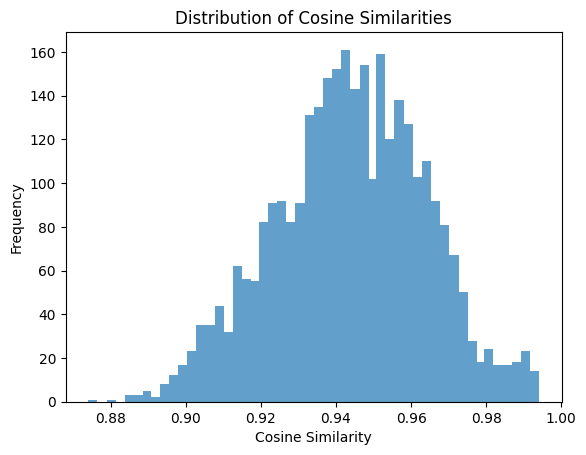

In [25]:
import matplotlib.pyplot as plt

plt.hist(cosine_similarities.cpu().numpy(), bins=50, alpha=0.7)
plt.title('Distribution of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

In [30]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, IntSlider

def visualize_tsne(perplexity):
    start = time.time()
    print("Computing embeddings...")
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=10)
    X_tsne = tsne.fit_transform(features)
    print(f"Done. Took {time.time()-start}")

    # Plotting
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_tsne[1:, 0], y=X_tsne[1:, 1], c=(cosine_similarities.cpu().numpy() > 0.97).astype(np.int), cmap='tab10', legend='full')
    # sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], c=labels, cmap='tab10', legend='full')
    plt.title(f'2D Visualization of High Dimensional Data with Perplexity: {perplexity}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

# Widget to adjust the perplexity
interact(visualize_tsne, perplexity=IntSlider(min=1, max=50, step=1, value=30))

interactive(children=(IntSlider(value=30, description='perplexity', max=50, min=1), Output()), _dom_classes=('…

<function __main__.visualize_tsne(perplexity)>

In [36]:
perplexity = 30
tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=10)
X_tsne = tsne.fit_transform(features)
len(images[1:]), X_tsne[1:, 0].shape, cosine_similarities.cpu().numpy().shape

(3164, (3164,), (3164, 1))

In [37]:
from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output, State, no_update

# App layout
app = JupyterDash(__name__)
app.layout = html.Div([
    dcc.Graph(id="tsne-graph"),
    dcc.Slider(
        id='perplexity-slider',
        min=1,
        max=50,
        value=30,  # Default value
        marks={str(i): str(i) for i in range(1, 51, 1)},
        step=1
    ),
    dcc.Tooltip(id="graph-tooltip"),
])

# Callback to update t-SNE plot based on perplexity slider
@app.callback(
    Output("tsne-graph", "figure"),
    Input("perplexity-slider", "value")
)
def update_tsne(perplexity):

    start = time.time()
    print("Computing embeddings...")
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=10)
    X_tsne = tsne.fit_transform(features)
    print(f"Done. Took {time.time()-start}")

    df = pd.DataFrame({
        "x": X_tsne[1:, 0],
        "y": X_tsne[1:, 1],
        "label": (cosine_similarities.squeeze().cpu().numpy() > 0.97).astype(np.int),
        "image": images[1:]
    })

    fig = go.Figure(data=[
        go.Scatter(
            x=df["x"],
            y=df["y"],
            mode="markers",
            marker=dict(colorscale='Viridis', color=df["label"], size=10, opacity=0.8),
            hoverinfo='none'
        )
    ])
    fig.update_layout(plot_bgcolor='rgba(255,255,255,0.1)')

    return fig

# Callback to display hover tooltip
@app.callback(
    Output("graph-tooltip", "show"),
    Output("graph-tooltip", "bbox"),
    Output("graph-tooltip", "children"),
    Input("tsne-graph", "hoverData"),
)
def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update
    pt = hoverData['points'][0]
    bbox = pt["bbox"]
    num = pt["pointIndex"]
    img_src = images[num]

    children = [
        html.Div([
            html.Img(src=img_src, style={"width": "100%"}),
            html.H3(f"Label: {labels[num]}", style={"color": "darkblue"})
        ], style={'width': '200px', 'white-space': 'normal'})
    ]

    return True, bbox, children


app.run_server(mode='jupyterlab')

Dash is running on http://127.0.0.1:8050/



Computing embeddings...
Done. Took 2.474571943283081


/tmp/ipykernel_569612/3000495462.py:35: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

